# Exploratory Data Analysis of Stimulus Triggered Averages
*Ian Malone*

### Load data and check structure

In [171]:
import pandas as pd

df_sta = pd.read_csv('C:\\Users\\Ian\\Google Drive\\IanGMalone\\UF\\Lab\\DataAndFigures\\Analysis\\df_STA_2020_11_25.csv')
df_sta.head()

,Animal,Day,Side,Stim_Amplitude,Sample,STA_Amplitude
0,S01,D04,Left,100.0,0,0.065894
1,S01,D04,Left,100.0,1,0.109876
2,S01,D04,Left,100.0,2,0.131164
3,S01,D04,Left,100.0,3,0.101857
4,S01,D04,Left,100.0,4,0.125714


In [172]:
df_sta.dtypes

Animal             object
Day                object
Side               object
Stim_Amplitude    float64
Sample              int64
STA_Amplitude     float64
dtype: object

#### For this analysis, we will only keep the left side EMG

In [173]:
df_sta = df_sta[df_sta["Side"] == 'Right']

In [174]:
print(df_sta.Animal.unique())
print(df_sta.Day.unique())
print(df_sta.Side.unique())
print(df_sta.Stim_Amplitude.unique())

['S01' 'S02' 'S03']
['D04' 'D06' 'D08']
['Right']
[100. 110. 120. 130. 140. 150. 160. 170. 180. 190. 200. 210. 220. 230.
 240. 250. 260. 270. 280. 290. 300. 310. 320. 330. 340. 350. 360. 370.
 380. 390. 400. 410. 420. 430. 440. 450. 460. 470. 480. 490. 500. 510.
 520. 530. 540. 550. 560. 570. 580. 590. 600.]


#### We will also change the 'Day' column to have integer values.

In [180]:
df_sta['Day'] = df_sta['Day'].str[-1].astype(int)
df_sta.head(), df_sta.dtypes

(     Animal  Day   Side  Stim_Amplitude  Sample  STA_Amplitude
 6150    S01    4  Right           100.0       0       0.119449
 6151    S01    4  Right           100.0       1       0.156867
 6152    S01    4  Right           100.0       2       0.173611
 6153    S01    4  Right           100.0       3       0.184769
 6154    S01    4  Right           100.0       4       0.171930,
 Animal             object
 Day                 int32
 Side               object
 Stim_Amplitude    float64
 Sample              int64
 STA_Amplitude     float64
 dtype: object)

### Plot stimulus triggered average waveforms
##### For each current amplitude, each animal, and each day

In [150]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# g = sns.FacetGrid(df_sta, col='Day', row='Animal', hue='Stim_Amplitude')
# g.map_dataframe(sns.lineplot, x='Sample', y='STA_Amplitude')
# g.set_axis_labels('30 ms duration', 'Ampltiude (V)')
# g.add_legend()


#### When you want to actually plot this with all the data, SUBSET! Only do day 01, 09 and 18
#### also, only do certain stim amplitudes

#### Observations
- Each animal will need to have MEPs viewed on a unique y-axis. While this will help in viewing the data, during analysis, animals with large scale EMG values will still dominate and potentially obscure interesting group trends in MEP shape, latency, and longitudinal change.
- Another approach is to normalize all MEP values between 0 and 1. This must be done for each individual animal and all days must be included in the normalization to preserve day-to-day changes. However, this normalization prevents direct comparisons between animals. Use this if you only care about the change over time for animals and not the absolute comparison of EMG values betweeen animals. This may be a valid approach due to variability in electrodes, implantation, etc. preventing meaningful comparison of MEP magnitude between animals.

### Calculate area under the stimulus triggered average curves 
##### For each current amplitude, each animal, and each day

In [181]:
df_sta.head()

,Animal,Day,Side,Stim_Amplitude,Sample,STA_Amplitude
6150,S01,4,Right,100.0,0,0.119449
6151,S01,4,Right,100.0,1,0.156867
6152,S01,4,Right,100.0,2,0.173611
6153,S01,4,Right,100.0,3,0.184769
6154,S01,4,Right,100.0,4,0.171930


The dataframe looks as expected. We now want to add a column that defines sample bins of interest so we can compare metrics at different latencies (e.g., how does the area under the curve differ in the bins 0 to 5 ms vs. 5 to 10 ms?). We will first convert 'Sample' to 'Time' and then define bins of interest.

In [182]:
sampling_frequency = 5000 # hertz
df_sta['Time'] = df_sta['Sample']/sampling_frequency # create time column based on samples and sampling frequency

bins = [0.001, 0.006, 0.011, 0.016, 0.021, 0.026] # define bins
#labels = ['1 to 6 ms', '6 to 11 ms', '11 to 16 ms', '16 to 21 ms', '21 to 26 ms'] # define bin labels
labels = [1, 2, 3, 4, 5]
df_sta['Time_Bin'] = pd.cut(df_sta['Time'], bins, labels=labels, right=False) # add Time_Bin column to dataframe
df_sta = df_sta.reindex(columns=['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Sample', 'Time', 'Time_Bin', 'STA_Amplitude'])

df_sta.head()

,Animal,Day,Side,Stim_Amplitude,Sample,Time,Time_Bin,STA_Amplitude
6150,S01,4,Right,100.0,0,0.0000,NaN,0.119449
6151,S01,4,Right,100.0,1,0.0002,NaN,0.156867
6152,S01,4,Right,100.0,2,0.0004,NaN,0.173611
6153,S01,4,Right,100.0,3,0.0006,NaN,0.184769
6154,S01,4,Right,100.0,4,0.0008,NaN,0.171930


Note that the NaN value for the first several rows caused by purposely excluding the first 1 ms of data in order to remove any stimulus artifacts. This can be changed.

We now need to integrate the stimulus triggered average curves to find the area beneath them. We can then compare these areas under the curve (AUCs) between groups, days, stimulus intensities, etc.

The trapezoidal rule provides a simple way to integrate a function but typically has much larger error than Simpson's rule without saving significant compute time. We will use Simpson's rule.

In [183]:
from scipy import integrate

df_auc = df_sta.groupby(['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Time_Bin'])['STA_Amplitude'].apply(integrate.simps).reset_index()
df_auc.rename(columns = {'STA_Amplitude':'STA_AUC'}, inplace = True)
df_auc.head()

,Animal,Day,Side,Stim_Amplitude,Time_Bin,STA_AUC
0,S01,4,Right,100.0,1,2.497616
1,S01,4,Right,100.0,2,2.492178
2,S01,4,Right,100.0,3,2.549094
3,S01,4,Right,100.0,4,2.191393
4,S01,4,Right,100.0,5,2.020577


### Exploratory Data Analysis

We have our final data frame to use for this analysis, df_auc, and we can start our EDA.

<AxesSubplot:xlabel='Day', ylabel='Animal'>

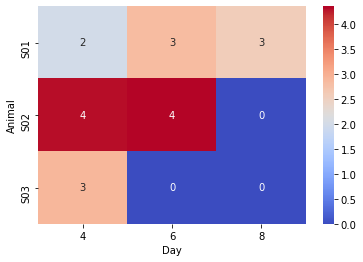

In [190]:
# Use a heatmap to look at animal (y), day (x), and mean AUC (heat)

df_animal_day = df_auc.groupby(['Animal', 'Day'])['STA_AUC'].mean().reset_index()
df_animal_day_pivot = df_animal_day.pivot(index='Animal', columns='Day', values='STA_AUC').fillna(0)
sns.heatmap(df_animal_day_pivot, annot=True, fmt='.0f', cmap="coolwarm")

### Other analyses

Peak to peak from stimulus triggered average for each current amplitude, each animal, each day
Latency from stimulus pulse to stimulus triggered average for each current amplitude, each animal, each day
Time domains of stimulus triggered average
Differences in any of these parameters based on time of day?
How are we going to present the impedance data in the Neilsen paper? I’m still not clear on this.
Additional things we can look at (e.g., wavelet, FFT, HMM, etc.)
Look in manuscript file for notes on ideas. Also look in Daily Notes on OneNote for papers that did EMG analysis well.